# AVIRIS-NG Plotting Notebook

This Jupyter notebook visualizes AVIRIS-NG (Airborne Visible/Infrared Imaging Spectrometer - Next Generation) hyperspectral data using [GeoIPS](https://github.com/NRLMMD-GEOIPS/geoips), the [AVIRIS-NG GeoIPS Plugin](https://github.com/biosafetylvl5/geoips-avris-ng) and interactive jupyter widgets.

## Overview

The notebook demonstrates:
- Loading AVIRIS-NG hyperspectral data
- Creating a static wavelength-specific visualization
- Extracting and plotting spectral profiles at specific locations
- Creating animations across wavelength bands

### Products

1. **Static Images**: Wavelength-specific visualizations with spectral profiles
2. **Interactive Plots**: Interactive parameter settings
3. **Animations**: Multi-wavelength time-series as MP4 files and GIFs
4. **Frame Sequences**: Individual animation frames for future use

In [1]:
from geoips.interfaces import readers as geoips_readers
from PIL import Image
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interactive
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from jupyter_helpers import plot_wavelength_image_with_spectrum_xarray, create_wavelength_animation, create_html_animation, create_hyperspectral_widgets

### Data Loading

## Data Format

The notebook expects AVIRIS-NG data in the standard format:
- File pattern: `ang[YYYYMMDD]t[HHMMSS]_corr_v2p5_img`
- Reflectance data (rfl) or radiance (rad)
- Corrected imagery format


### Example Data

The notebook includes examples using data from:
- Date: March 21, 2017
- Time: 19:40:12 UTC and 21:31:41 UTC
- Processing version: v2p5 (corrected reflectance)

In [2]:
reader = geoips_readers.get_plugin("geoips_aviris_ng") # Initialize the AVIRIS-NG reader

In [3]:
data = reader(fnames=["/data/ang20170321t194012_rfl_v2p5/ang20170321t194012_corr_v2p5_img"]) # Load AVIRIS-NG data

### Static Visual

This creates a static plot showing:
- Hyperspectral image at a specific wavelength (500nm)
- Spectral profile at a selected point
- Crosshair overlay for point identification
- North arrow for orientation (the orientation data is *NOT* stored in data files so this must be set manually.)

*Parameters:*
- `wavelength`: 500nm (0.5um)
- `center_x`, `center_y`: Image center coordinates (361, 3600)
- `px`, `py`: Point coordinates for spectral extraction (400, 3600)
- `window_size`: 800 pixels
- `north_arrow_angle`: 352 degrees (360-8)

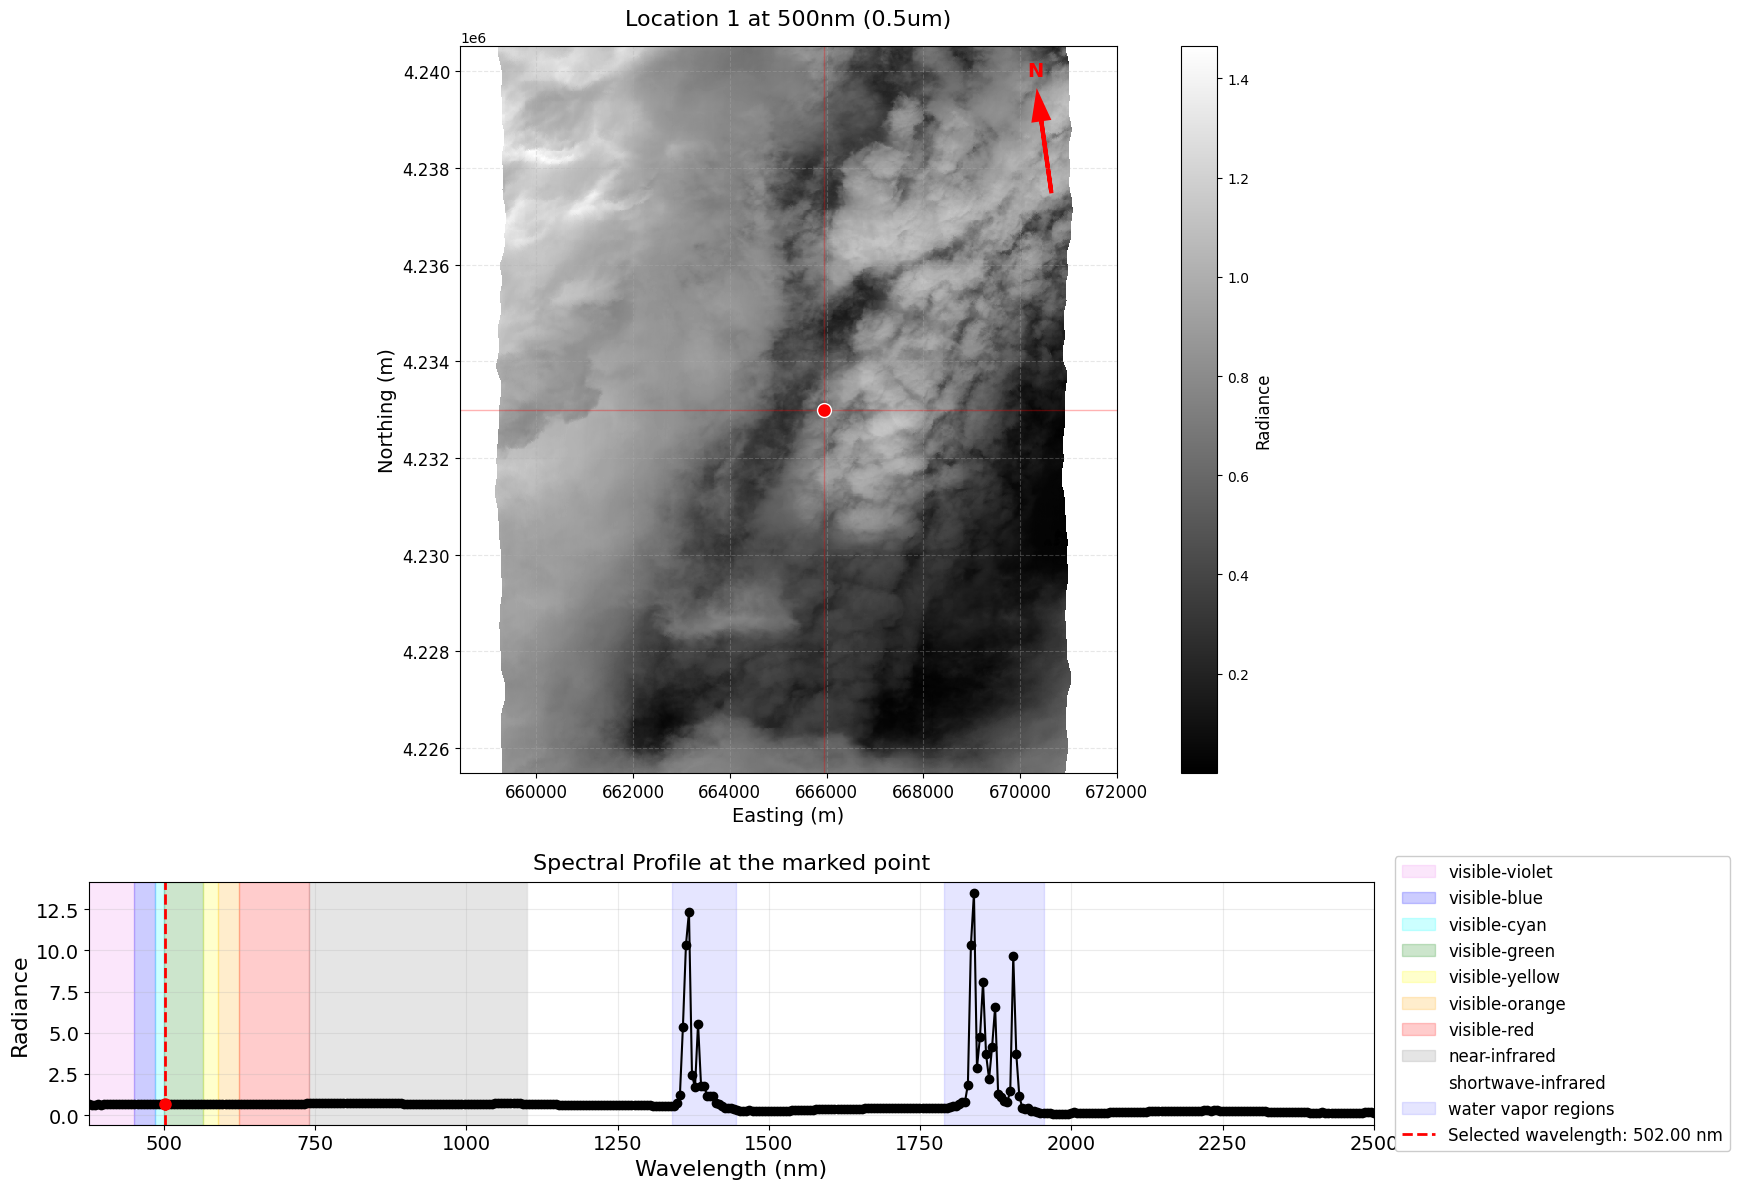

In [4]:
%matplotlib inline
fig1 = plot_wavelength_image_with_spectrum_xarray(
    dataset=data,
    wavelength=500,
    center_x=361,
    center_y=3600,
    px=400,
    py=3600,
    site_name="Site 1",
    window_size=800,
    north_arrow_angle=(360-8),
    image_title="Location 1 at 500nm (0.5um)",
    spectrum_title="Spectral Profile at the marked point",
    show_crosshair=True,
    crosshair_color='red',  # More visible color
    crosshair_alpha=0.3,    # Higher opacity
    crosshair_linewidth=1, # Thicker lines
    spectrum_linestyle="-",
    spectrum_marker="o"
)
plt.show()

### Interactive Section

The notebook provides an interactive widget for creating animations or static plots.

In [5]:
%matplotlib inline

hyperspectral_widgets = create_hyperspectral_widgets(
    dataset=data,
    default_values={
        'wavelength': 500,
        'center_x': 361,
        'center_y': 3600,
        'px': 400,
        'py': 3600,
        'site_name': "Site 1",
        'window_size': 800,
        'north_arrow_angle': (360-8),
        'image_title': "Location 1 at 500nm (0.5um)",
        'spectrum_title': "Spectral Profile at the marked point",
        'show_crosshair': True,
        'crosshair_color': 'red',
        'crosshair_alpha': 0.3,
        'crosshair_linewidth': 1,
        'create_animation': False,
        'wl_start': 400,
        'wl_end': 900,
        'wl_step': 100,
        'frame_duration': 100,
        'animation_title_template': "Location 1 at {wavelength:.0f}nm ({wavelength_um:.1f}um)",
        'save_animation': True,
        'save_path': "location1_wavelength_animation_slow.mp4",
        'save_frames': True,
        'frames_directory': "animation_frames",
        'vmin': 0,
        'vmax': 1.8
    }
)

hyperspectral_widgets